In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

In [2]:
import numpy as np  # for array
import pandas as pd  # for csv files and dataframe
import matplotlib.pyplot as plt  # for plotting
import seaborn as sns  # plotting
from scipy import stats
from tqdm import tqdm  # Progress bar

import pickle  # To load data int disk
from prettytable import PrettyTable  # To print in tabular format

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler  # Standardizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder  # One hot Encoder
from scipy.sparse import csr_matrix  # For sparse matrix

from sklearn.model_selection import train_test_split
# Different Models
from sklearn.linear_model import LogisticRegression, SGDClassifier  # LR
from sklearn.svm import LinearSVC  # SVM
from sklearn.tree import DecisionTreeClassifier  #DT
from sklearn.ensemble import RandomForestClassifier  # RF
import xgboost as xgb  #XGB

from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer  # Scoring functions
from sklearn.metrics import auc, f1_score, roc_curve, roc_auc_score  # Scoring fns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV  # Cross validation
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier

from sklearn import metrics

# from keras.preprocessing.sequence import pad_sequences

# from keras.models import Sequential

# from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# from keras.layers import Activation, Dense, Dropout, Embedding, LSTM

# import re

# from IPython.display import display

# import os

# import string

# import time

# import random

# import matplotlib.pyplot as plt

# from tensorflow.keras.datasets import imdb

# random.seed(10)


%matplotlib inline

In [3]:
file_path = "./datasets/final_UNSW-NB15"
# Train and Test data
x_train, y_train = pickle.load(open(file_path+'/final_train.pkl', 'rb'))
x_test, y_test = pickle.load(open(file_path+'/final_test.pkl', 'rb'))

# Dictionaries
saved_dict = pickle.load(open(file_path+'/saved_dict.pkl', 'rb'))
mode_dict = pickle.load(open(file_path+'/mode_dict.pkl', 'rb'))

# Standard scaler
scaler = pickle.load(open(file_path+'/scaler.pkl', 'rb'))

# Onehot encoders
ohe_proto = pickle.load(open(file_path+'/ohe_proto.pkl', 'rb'))
ohe_service = pickle.load(open(file_path+'/ohe_service.pkl', 'rb'))
ohe_state = pickle.load(open(file_path+'/ohe_state.pkl', 'rb'))

label_encoder = pickle.load(open(file_path+'/label_encoder.pkl', 'rb'))


In [4]:
class_labels = label_encoder.classes_
print(class_labels)
encoded_values = label_encoder.transform(['analysis', 'backdoor', 'dos', 'exploits', 'fuzzers', 'generic', 'normal', 'reconnaissance', 'shellcode', 'worms'])
print(encoded_values)
mapping = dict(zip(class_labels, encoded_values))
print(mapping)

['analysis' 'backdoor' 'dos' 'exploits' 'fuzzers' 'generic' 'normal'
 'reconnaissance' 'shellcode' 'worms']
[0 1 2 3 4 5 6 7 8 9]
{'analysis': np.int64(0), 'backdoor': np.int64(1), 'dos': np.int64(2), 'exploits': np.int64(3), 'fuzzers': np.int64(4), 'generic': np.int64(5), 'normal': np.int64(6), 'reconnaissance': np.int64(7), 'shellcode': np.int64(8), 'worms': np.int64(9)}


## Pipeline functions

In [5]:
#------------------------------------------------------------------------------------------
# Data Cleaning
#------------------------------------------------------------------------------------------
def clean_data(data):
    '''
    Cleans given raw data. Performs various cleaning, removes Null and wrong values.
    Check for columns datatype and fix them.
    '''
    numerical_col = data.select_dtypes(include=np.number).columns  # All the numerical columns list
    categorical_col = data.select_dtypes(exclude=np.number).columns  # All the categorical columns list
    
    # Cleaning the data
    for col in data.columns:
        val = mode_dict[col]  # Mode value of the column in train data
        data[col] = data[col].fillna(value=val)
        data[col] = data[col].replace(' ', value=val)
        data[col] = data[col].apply(lambda x:"none" if x=="-" else x)

        # Fixing binary columns
        if col in saved_dict['binary_col']:
            data[col] = np.where(data[col]>1, val, data[col])

    # Fixing datatype of columns
    bad_dtypes = list(set(categorical_col) - set(saved_dict['cat_col']))
    for bad_col in bad_dtypes:
        data[col] = data[col].astype(float)
    
    return data

#------------------------------------------------------------------------------------------
# Feature Engineering: Apply log1p
#------------------------------------------------------------------------------------------
def apply_log1p(data):
    '''
    Performs FE on the data. Apply log1p on the specified columns create new column and remove those original columns.
    '''
    for col in saved_dict['log1p_col']:
        new_col = col + '_log1p'  # New col name
        data[new_col] = data[col].apply(np.log1p)  # Creating new column on transformed data
        data.drop(col, axis=1, inplace=True)  # Removing old columns
    return data

#------------------------------------------------------------------------------------------
# Standardizing: Mean centering an d varience scaling
#------------------------------------------------------------------------------------------
def standardize(data):
    '''
    Stanardize the given data. Performs mean centering and varience scaling.
    Using stanardscaler object trained on train data.
    '''
    data[saved_dict['num_col']] = scaler.transform(data[saved_dict['num_col']])
    return data

#------------------------------------------------------------------------------------------
# Onehot encoding of categorical columns
#------------------------------------------------------------------------------------------
def ohencoding(data):
    '''
    Onehot encoding the categoricla columns.
    Add the ohe columns with the data and removes categorical columns.
    Using Onehotencoder objects trained on train data.
    '''
    # Onehot encoding cat col using onehotencoder objects
    X = ohe_service.transform(data['service'].values.reshape(-1, 1))
    Xm = ohe_proto.transform(data['proto'].values.reshape(-1, 1))
    Xmm = ohe_state.transform(data['state'].values.reshape(-1, 1))
    
    # Adding encoding data to original data
    data = pd.concat([data,
                      pd.DataFrame(Xm.toarray(), columns=['proto_'+i for i in ohe_proto.categories_[0]]),
                      pd.DataFrame(X.toarray(), columns=['service_'+i for i in ohe_service.categories_[0]]),
                      pd.DataFrame(Xmm.toarray(), columns=['state_'+i for i in ohe_state.categories_[0]])],
                      axis=1)
    
    # Removing cat columns
    data.drop(['proto', 'service', 'state'], axis=1, inplace=True)
    return data

In [6]:
def labelcoding(data):
    data= label_encoder.transform(data) 
    return data

In [7]:
def get_final_data(data, saved_dict=saved_dict, mode_dict=mode_dict):
    '''
    This functions takes raw input and convert that to model required output.
    '''
    data.reset_index(drop=True, inplace=True)
    data.columns = saved_dict['columns']
    
    data['network_bytes'] = data['dbytes'] + data['sbytes']
    
    dropable_col = saved_dict['to_drop'] + saved_dict['corr_col']
    data.drop(columns=dropable_col, inplace=True)
    
    data = clean_data(data)
    data = apply_log1p(data)
    data = standardize(data)
    data = ohencoding(data)
    
    return data

In [8]:
x_test.columns

Index(['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes',
       'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'sload', 'dload',
       'spkts', 'dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz',
       'dmeansz', 'trans_depth', 'res_bdy_len', 'sjit', 'djit', 'stime',
       'ltime', 'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat',
       'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login',
       'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'label'],
      dtype='object')

In [9]:
ohe_service.categories_

[array(['dhcp', 'dns', 'ftp', 'ftp-data', 'http', 'irc', 'none', 'pop3',
        'radius', 'smtp', 'snmp', 'ssh', 'ssl'], dtype=object)]

In [10]:
# Using pipeline to prepare test data
x_test = get_final_data(x_test)

In [11]:
y_test=y_test.fillna(value="normal").apply(lambda x:x.strip().lower())
y_test = y_test.replace('backdoors','backdoor', regex=True).apply(lambda x: x.strip().lower())
y_test= labelcoding(y_test)
y_test = pd.DataFrame(y_test,columns=['attack_cat',],)
y_test=y_test['attack_cat']

In [12]:
y_test.unique()

array([6, 3, 5, 4, 7, 2, 0, 1, 8, 9])

In [13]:
x_train.columns.tolist()

['sttl',
 'dttl',
 'swin',
 'trans_depth',
 'res_bdy_len',
 'stime',
 'sintpkt',
 'dintpkt',
 'tcprtt',
 'synack',
 'ackdat',
 'is_sm_ips_ports',
 'ct_state_ttl',
 'ct_flw_http_mthd',
 'is_ftp_login',
 'ct_ftp_cmd',
 'ct_srv_src',
 'ct_dst_ltm',
 'ct_src_ltm',
 'ct_dst_sport_ltm',
 'dur_log1p',
 'sbytes_log1p',
 'dbytes_log1p',
 'sload_log1p',
 'dload_log1p',
 'spkts_log1p',
 'stcpb_log1p',
 'dtcpb_log1p',
 'smeansz_log1p',
 'dmeansz_log1p',
 'sjit_log1p',
 'djit_log1p',
 'network_bytes_log1p',
 'proto_3pc',
 'proto_a/n',
 'proto_aes-sp3-d',
 'proto_any',
 'proto_argus',
 'proto_aris',
 'proto_arp',
 'proto_ax.25',
 'proto_bbn-rcc',
 'proto_bna',
 'proto_br-sat-mon',
 'proto_cbt',
 'proto_cftp',
 'proto_chaos',
 'proto_compaq-peer',
 'proto_cphb',
 'proto_cpnx',
 'proto_crtp',
 'proto_crudp',
 'proto_dcn',
 'proto_ddp',
 'proto_ddx',
 'proto_dgp',
 'proto_egp',
 'proto_eigrp',
 'proto_emcon',
 'proto_encap',
 'proto_esp',
 'proto_etherip',
 'proto_fc',
 'proto_fire',
 'proto_ggp',
 'pr

In [14]:
x_train.shape, y_train.shape

((1778032, 197), (1778032,))

In [15]:
x_test.shape, y_test.shape

((762015, 197), (762015,))

In [16]:
all(x_train.columns == x_test.columns)

True

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

def encode_attack_non_attack(df):
    #something broke, so i'm doing this, i'm tired
    df=pd.DataFrame(df)
    replace_values = [9, 8, 7, 5, 4, 3, 2, 1, 0]
    new_df = df.replace(replace_values, 1).replace(6, 0)
    return new_df


# def calculate_far(y_true, y_pred):
#     tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
#     far = fp / (fp + tn)
#     return 0

def false_alarm_rate(y_true, y_pred):
    """
    This function will return False Alarm Rate for given true and predicted values.
    False Alarm Rate is average of False Negetive Rate and False Positive Rate
    """
    # return calculate_far(y_true, y_pred)
    y_true=encode_attack_non_attack(y_true)
    y_pred = encode_attack_non_attack(y_pred)

    c_matrix=confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = c_matrix.ravel()
    
    labels= ['non-attack', 'attack']
    plt.figure(figsize=(8, 6))  # Adjust figure size as needed
    sns.heatmap(c_matrix, annot=True, cmap='Blues', fmt='d',xticklabels=labels, yticklabels=labels)  # Customize colors and format
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for General Attack Detection')
    plt.show()
    FPR = fp / (fp + tn)  # False positive rate
    FNR = fn / (fn + tp)  # False negetive rate
    return (FPR+FNR)/2  # False alarm rate


def evaluate_result(y_true, y_pred, model_name):
    far=false_alarm_rate(y_true, y_pred)
    # test_f1 = f1_score(y_test, y_test_pred, average=None)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred,average='weighted')

    # cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
    
    x = PrettyTable()
    x.field_names = [ 'Accuracy','Precision','Recall','F1','False Alarm Rate']
    x.add_row([accuracy,precision,recall,f1,far])
    print(x)

    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

    # Create a heatmap with clear labels and annotations
    plt.figure(figsize=(8, 6))  # Adjust figure size as needed
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d')  # Customize colors and format
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    # cm_display.plot()
    # plt.show()
    
    # Returning scores
    return accuracy

In [19]:
old_x_train=x_train
old_y_train=y_train
old_x_test=x_test
old_y_test=y_test

In [20]:
old_x_train.shape

(1778032, 197)

In [72]:
line_count=100000

x_train=old_x_train.head(line_count)
y_train=old_y_train.head(line_count)
x_test=old_x_test.head(line_count)
y_test=old_y_test.head(line_count)

## Long term short term neural network

In [ ]:
# sequence_length = 300
# batch_size = 128

# X_train_seq = pad_sequences( x_train, maxlen = sequence_length)
# X_test_seq = pad_sequences( x_test, maxlen = sequence_length)

In [ ]:
# model = Sequential()

# model.add(e)

# model.add(LSTM( 128 , dropout = 0.25, recurrent_dropout = 0.25))

# model.add(Dense(1, activation = 'sigmoid' ))

# model.summary()

# model.compile( optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'] )

# early_stopper = EarlyStopping( monitor = 'val_acc' , min_delta = 0.0005, patience = 3 )

# reduce_lr = ReduceLROnPlateau( monitor = 'val_loss' , patience = 2 , cooldown = 0)

# callbacks = [ reduce_lr , early_stopper]

# train_history = model.fit( X_train_seq , y_train , batch_size = batch_size, epochs = 5,validation_split = 0.1 , verbose = 1 , callbacks = callbacks)

# score = model.evaluate( X_test_seq , y_test , batch_size = batch_size)

# print( "Accuracy: {:0.4}".format( score[1] ))

# print( "Loss:", score[0] )

## SVM

In [73]:
from sklearn import svm
svm_clf = svm.SVC()
svm_clf.fit(x_train,y_train)

SVC()

In [74]:
svm_y_test_pred=svm_clf.predict(x_test)

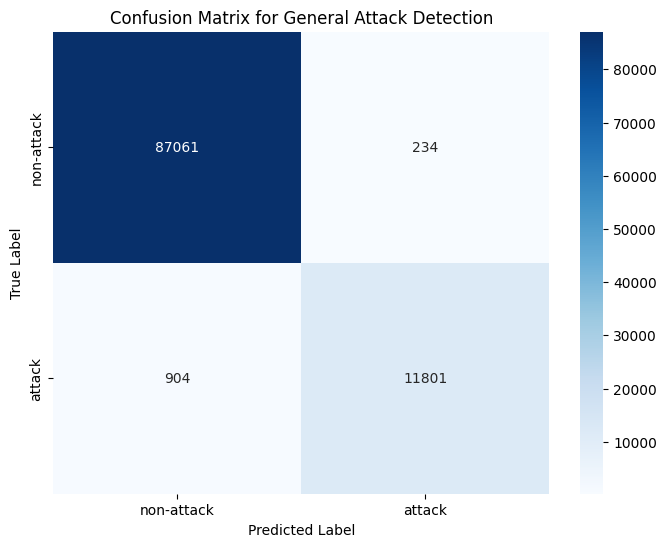

+----------+--------------------+---------+--------------------+----------------------+
| Accuracy |     Precision      |  Recall |         F1         |   False Alarm Rate   |
+----------+--------------------+---------+--------------------+----------------------+
| 0.97425  | 0.9706414350891454 | 0.97425 | 0.9696961604679784 | 0.036916827616076245 |
+----------+--------------------+---------+--------------------+----------------------+


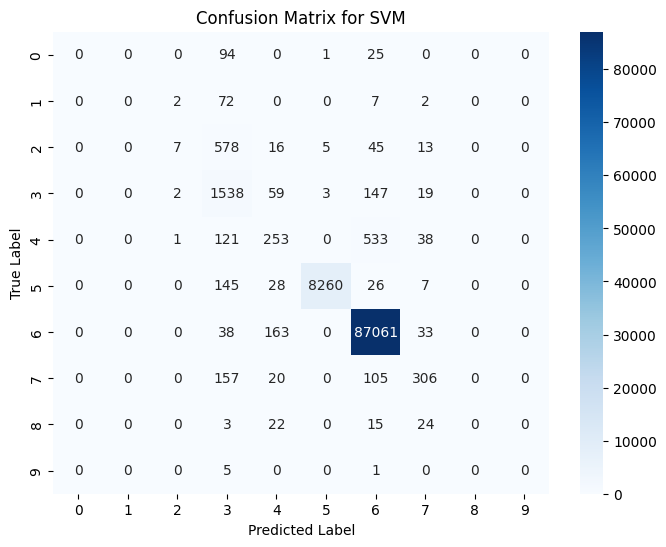

In [75]:
dt_acc =evaluate_result(y_test, svm_y_test_pred, 'SVM')

## Decision Tree


In [76]:
dt_classifier = DecisionTreeClassifier(max_depth=10, min_samples_split=6, min_samples_leaf=9)
dt_classifier.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=9, min_samples_split=6)

In [77]:
dt_y_test_pred=dt_classifier.predict(x_test)

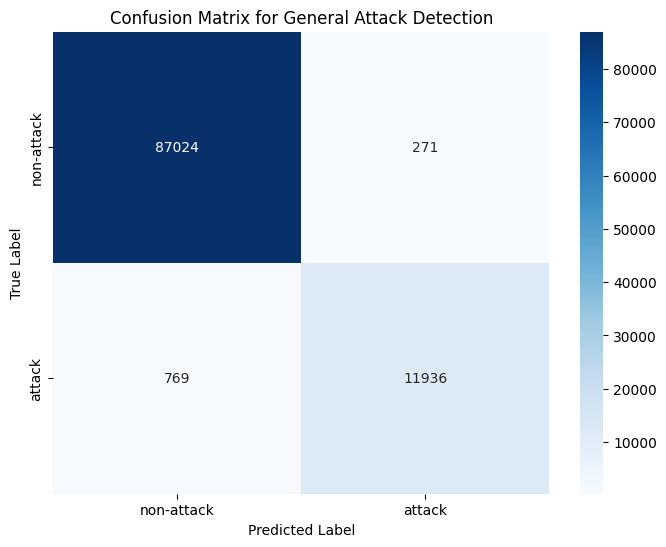

+----------+--------------------+---------+--------------------+----------------------+
| Accuracy |     Precision      |  Recall |         F1         |   False Alarm Rate   |
+----------+--------------------+---------+--------------------+----------------------+
| 0.97605  | 0.9720792053086942 | 0.97605 | 0.9728065622178379 | 0.031815883748463454 |
+----------+--------------------+---------+--------------------+----------------------+


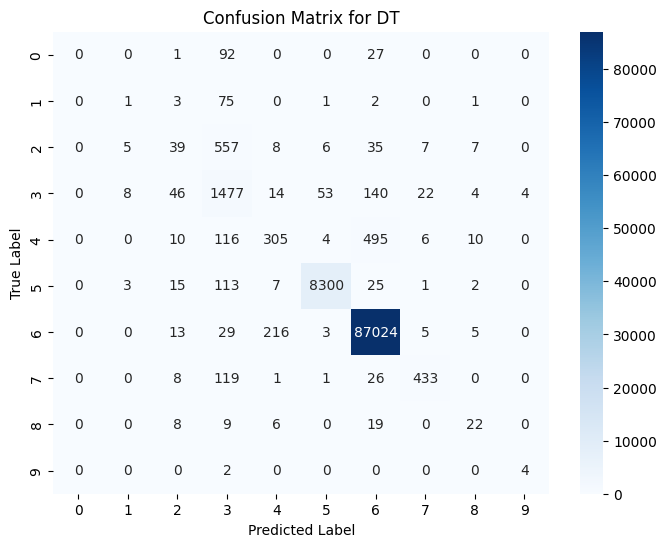

In [79]:
dt_acc =evaluate_result(y_test, dt_y_test_pred, 'DT')

## Logistic Regression


In [80]:
# import numpy
# from sklearn import linear_model

# #Reshaped for Logistic function.
# # X = numpy.array([3.78, 2.44, 2.09, 0.14, 1.72, 1.65, 4.92, 4.37, 4.96, 4.52, 3.69, 5.88]).reshape(-1,1)
# # y = numpy.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1])

# logr = linear_model.LogisticRegression()
# logr.fit(x_train,y_train)

# #predict if tumor is cancerous where the size is 3.46mm:
# # predicted = logr.predict(numpy.array([3.46]).reshape(-1,1))
# # print(predicted) 

In [81]:
# lr_y_test_pred = logr.predict(x_test)
# lr_acc =evaluate_result(y_test, lr_y_test_pred, 'LR')

In [82]:
# with open('datasets/final_UNSW-NB15/my_lr.pkl', 'wb') as f:
#     pickle.dump(logr, f)

## Random Forest

In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
# X, y = make_classification(n_samples=1000, n_features=4,
#                            n_informative=2, n_redundant=0,
#                            random_state=0, shuffle=False)
rf_clf = RandomForestClassifier(max_depth=22, random_state=0)
rf_clf.fit(x_train,y_train)

RandomForestClassifier(max_depth=22, random_state=0)

In [84]:
rf_y_test_pred=rf_clf.predict(x_test)

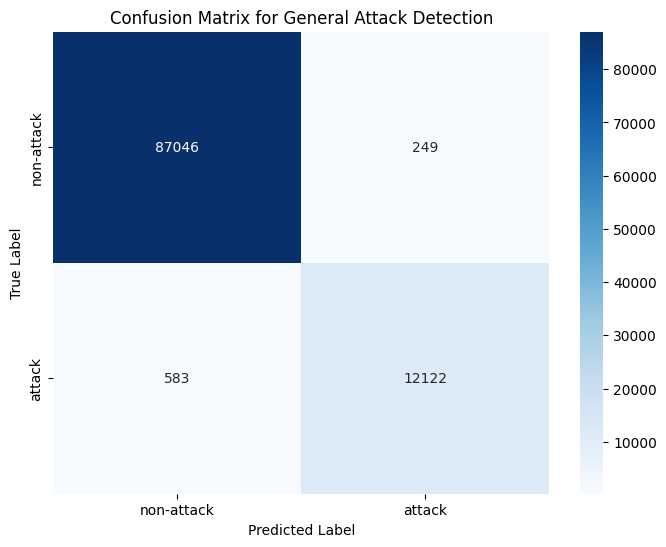

+----------+--------------------+---------+--------------------+----------------------+
| Accuracy |     Precision      |  Recall |         F1         |   False Alarm Rate   |
+----------+--------------------+---------+--------------------+----------------------+
| 0.97778  | 0.9755572746990845 | 0.97778 | 0.9761872152047045 | 0.024369921465975077 |
+----------+--------------------+---------+--------------------+----------------------+


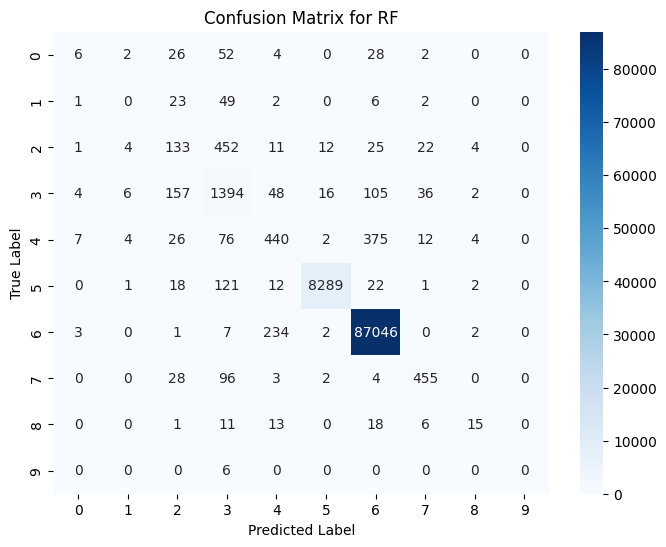

In [85]:
lr_acc =evaluate_result(y_test, rf_y_test_pred, 'RF')

In [86]:
with open('datasets/final_UNSW-NB15/my_rf.pkl', 'wb') as f:
    pickle.dump(rf_clf, f)

## XGBBoost

In [87]:
from xgboost import XGBClassifier
# read data
# from sklearn.datasets import load_iris
# from sklearn.model_selection import train_test_split
# data = load_iris()
# X_train, X_test, y_train, y_test = train_test_split(data['data'], data['target'], test_size=.2)
# create model instance
bst = XGBClassifier(n_estimators=400, max_depth=12, learning_rate=0.1, colsample_bylevel=0.5, subsample=0.1, n_jobs=-1)
# fit model
bst.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.5, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [88]:
xgb_y_test_pred=bst.predict(x_test)

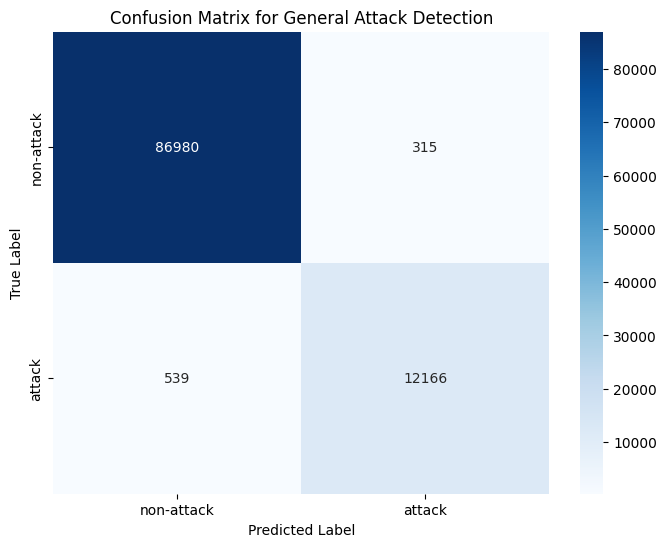

+----------+--------------------+--------+--------------------+----------------------+
| Accuracy |     Precision      | Recall |         F1         |   False Alarm Rate   |
+----------+--------------------+--------+--------------------+----------------------+
|  0.9769  | 0.9753061023516054 | 0.9769 | 0.9759233429513596 | 0.023016348258343793 |
+----------+--------------------+--------+--------------------+----------------------+


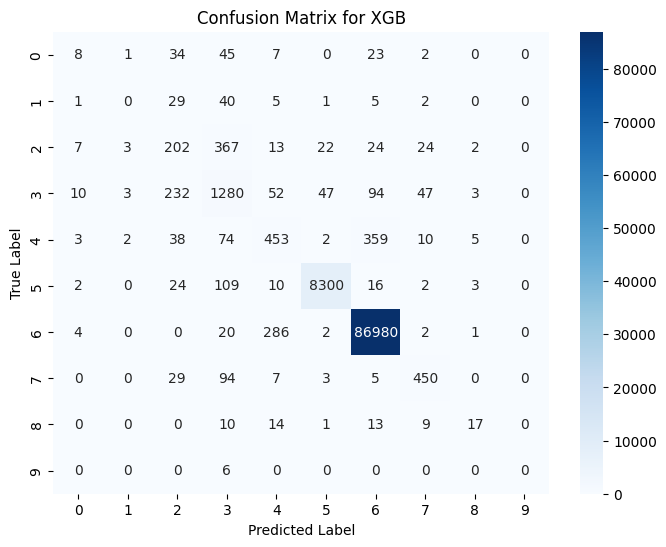

In [89]:
xgb_acc =evaluate_result(y_test, xgb_y_test_pred, 'XGB')

In [90]:
with open('datasets/final_UNSW-NB15/my_xgb.pkl', 'wb') as f:
    pickle.dump(bst, f)

## Ensemble

In [91]:
from sklearn.ensemble import VotingClassifier
# Initializing all the 3 classifiers with best found parameters
dt_clf = DecisionTreeClassifier(max_depth=10, min_samples_split=6, min_samples_leaf=9)
rf_clf = RandomForestClassifier(criterion='gini', max_depth=22, min_samples_split=6, n_estimators=300, n_jobs=-1)
xgb_clf = xgb.XGBClassifier(n_estimators=400, max_depth=12, learning_rate=0.1, colsample_bylevel=0.5, subsample=0.1, n_jobs=-1)
v_clf = VotingClassifier(estimators=[('lr', dt_clf), ('rf', rf_clf), ('xgb', xgb_clf)], voting='soft', n_jobs=-1)

In [92]:
v_clf.fit(x_train, y_train)

VotingClassifier(estimators=[('lr',
                              DecisionTreeClassifier(max_depth=10,
                                                     min_samples_leaf=9,
                                                     min_samples_split=6)),
                             ('rf',
                              RandomForestClassifier(max_depth=22,
                                                     min_samples_split=6,
                                                     n_estimators=300,
                                                     n_jobs=-1)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=0.5,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            earl...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=12,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=400, n_jobs=-1,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                 n_jobs=-1, voting='soft')

In [93]:
v_clf_y_test_pred=v_clf.predict(x_test)

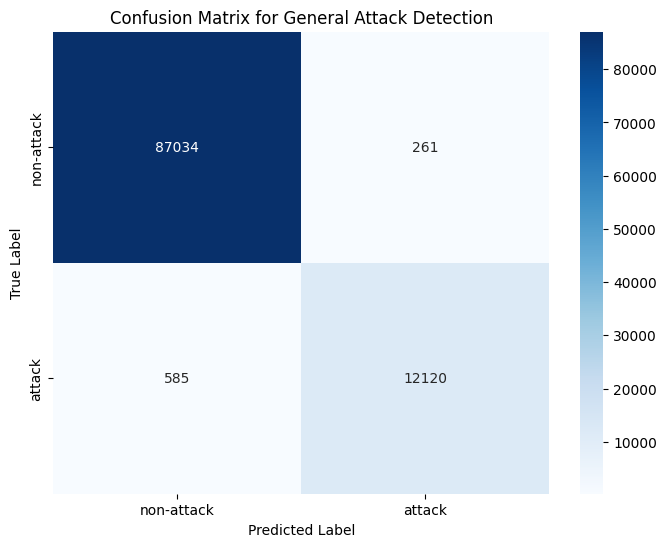

+----------+--------------------+---------+--------------------+----------------------+
| Accuracy |     Precision      |  Recall |         F1         |   False Alarm Rate   |
+----------+--------------------+---------+--------------------+----------------------+
| 0.97799  | 0.9758862919304111 | 0.97799 | 0.9764969357545628 | 0.024517363094497053 |
+----------+--------------------+---------+--------------------+----------------------+


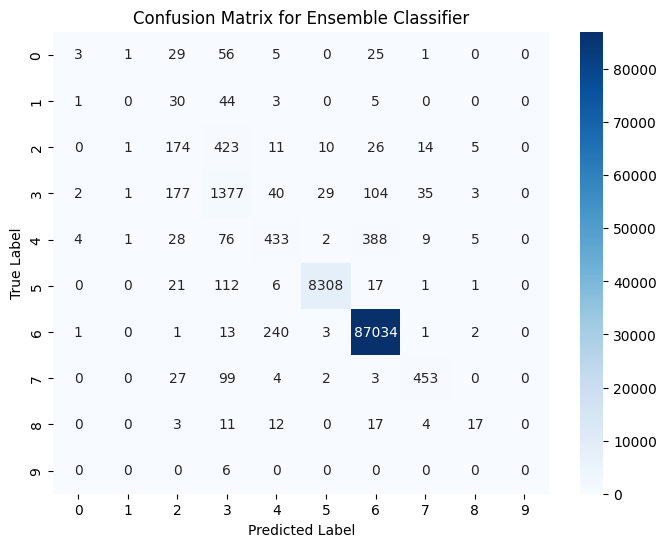

In [94]:
v_clf_acc =evaluate_result(y_test, v_clf_y_test_pred, 'Ensemble Classifier')

In [95]:
with open('datasets/final_UNSW-NB15/my_ensemble_clf.pkl', 'wb') as f:
    pickle.dump(v_clf, f)